# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para Pessoas Físicas no município do Rio de Janeiro 

### Contexto

No Airbnb, qualquer pessoa que queira alugar por diária um imóvel ou um cômodo dele pode fazê-lo facilmente através de sua plataforma.

É criado um perfil de _host_ (pessoa que está alugando o imóvel por diária) e então cria-se o anúncio do imóvel.

Nesse anúncio, o _host_ deve descrever as características do imóvel da maneira mais detalhada possível, para que assim os locadores possam escolher o imóvel que melhor atenda às suas necessidades.

Há dezenas de personalizações possíveis de serem aplicadas ao anúncio, como quantidade de quartos, banheiros, se há TV a cabo, acesso à internet, os tipos de cama etc.

### Objetivo

Construir um modelo que gere uma sugestão de preço de diária para imóveis de médio padrão (nem muito caros nem muito baratos), baseando-se no histórico de preços e características dos imóveis disponíveis na base de dados.

Esse modelo poderá ser utilizado tanto para alguém que queira alugar seu imóvel, quanto para alguém que esteja interessado em ser um hóspide e queira conferir se o preço está acima, abaixo ou equivalente ao sugerido pelo modelo.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Essa solução é inspirada tanto na do Allan Bruno do kaggle no Notebook https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb quanto na solução desenvolvida no curso Python Impressionador da Hashtag.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredita-se que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no Rio de Janeiro.
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos, acesso ao metrô).
- Adicionais/Comodidades podem ter um impacto significativo, visto que há muitos prédios e casas antigos no Rio de Janeiro.

### Importar Bibliotecas e Bases de Dados

In [1]:
#Conjunto de bibliotecas utilizadas
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidar Base de Dados

In [2]:
dataset_path = pathlib.Path(r'dataset') #obtendo o caminho do dataset
base_airbnb = pd.DataFrame() #criando um dataframe
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8,
         'set':9, 'out':10, 'nov':11, 'dez':12} #dicionario com meses e seus respectivos numeros
#lendo todos os arquivos csv e unificando-os
for arquivo in dataset_path.iterdir():
    df = pd.read_csv(dataset_path / arquivo.name)
    
    nome_mes = arquivo.name[:3] #pegando os 3 primeiros caracteres para obter o nome do mes
    mes = meses[nome_mes] #usando o dicionario para pegar o numero do mes
    ano = arquivo.name[-8:] #pegando os 8 ultimos caracteres
    ano = int(ano.replace('.csv','')) #removendo '.csv' para ficar somente com o ano
    
    df['ano'] = ano #adicionando coluna de ano
    df['mes'] = mes #adicionando coluna de mes
    
    base_airbnb = base_airbnb.append(df) #adicionado dados ao dataframe


C:\Users\leoni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\leoni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\leoni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


- Como existem muitas colunas, o modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que muitas colunas não serão necessárias para o modelo.
- Por isso serão excluídas algumas colunas da base.
- Tipos de colunas que serão excluídas:
    1. Ids, links e informações não relevantes para o modelo.
    2. Colunas repetidas ou extremamente parecidas com outras - que dão a mesma informação para o modelo (exemplo: Data x Ano/mês).
    3. Colunas preenchidas com texto livre -> não será feito nenhum tipo de processamento de linguagem natural.
    4. Colunas em que todos ou quase todos os valores são iguais.
    

- Para isso, será criado um arquivo em excel com os 1000 primeiros registros para fazer uma **análise qualitativa**.

### Análise Qualitativa

In [3]:
base_airbnb.head(1000).to_csv('primeiros_100_registros.csv', sep=';')

In [4]:
#Avaliando conteudos da coluna 'experiences_offered'
print(base_airbnb[['experiences_offered']].value_counts())
#Ela possui 902210 linhas condendo o valor 'none'

experiences_offered
none                   902210
dtype: int64


In [5]:
#Verificando quantos valores das colunas 'host_listings_count' e 'host_total_listings_count' são iguais
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())
#Elas possuem 901750 linhas com valores iguais

True     901750
False       460
dtype: int64


In [6]:
print(base_airbnb[['square_feet']].isnull().sum())
#A coluna 'square_feet' possui 888162 linhas nulas

square_feet    888162
dtype: int64


- Após a análise qualitativa das colunas, levando em conta os critérios explicados acima, serão mantidaws as seguintes colunas:

In [7]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
base_airbnb.head(10)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


host_response_time host_response_rate host_is_superhost  \
0                 NaN                NaN                 f   
1      within an hour               100%                 t   
2      within an hour               100%                 f   
3      within an hour               100%                 f   
4      within an hour               100%                 t   
5      within an hour               100%                 t   
6      within an hour               100%                 t   
7        within a day                50%                 f   
8  within a few hours               100%                 f   
9      within an hour                94%                 f   

   host_listings_count   latitude  longitude property_type        room_type  \
0                  1.0 -22.946854 -43.182737     Apartment  Entire home/apt   
1                  2.0 -22.965919 -43.178962   Condominium  Entire home/apt   
2                  1.0 -22.985698 -43.201935     Apartment  Entire home/apt   
3                  3.0 -22.977117 -43.190454     Apartment  Entire home/apt   
4                  1.0 -22.983024 -43.214270     Apartment  Entire home/apt   
5                  1.0 -22.988165 -43.193588     Apartment  Entire home/apt   
6                  1.0 -22.981269 -43.190457          Loft  Entire home/apt   
7                  1.0 -22.966808 -43.186574     Apartment  Entire home/apt   
8                  3.0 -22.921990 -43.183836     Apartment  Entire home/apt   
9                  6.0 -22.986333 -43.202563     Apartment  Entire home/apt   

   accommodates  bathrooms  ...  review_scores_cleanliness  \
0             4        1.0  ...                        9.0   
1             5        1.0  ...                        9.0   
2             2        1.0  ...                       10.0   
3             3        1.0  ...                       10.0   
4             3        1.0  ...                       10.0   
5             3        1.5  ...                        9.0   
6             2        1.0  ...                       10.0   
7             3        1.0  ...                        NaN   
8             3        1.0  ...                        4.0   
9            14        7.0  ...                        9.0   

   review_scores_checkin review_scores_communication review_scores_location  \
0                    9.0                         9.0                    9.0   
1                   10.0                        10.0                    9.0   
2                   10.0                        10.0                   10.0   
3                   10.0                        10.0                   10.0   
4                   10.0                        10.0                   10.0   
5                   10.0                        10.0                   10.0   
6                   10.0                        10.0                   10.0   
7                    NaN                         NaN                    NaN   
8                    8.0                         6.0                    6.0   
9                    9.0                         8.0                   10.0   

  review_scores_value instant_bookable is_business_travel_ready  \
0                 9.0                f                        f   
1                 9.0                t                        f   
2                 9.0                f                        f   
3                 9.0                f                        f   
4                 9.0                t                        f   
5                 9.0                f                        f   
6                10.0                t                        f   
7                 NaN                f                        f   
8                 4.0                f                        f   
9                 8.0                t                        f   

           cancellation_policy   ano  mes  
0  strict_14_with_grace_period  2018    4  
1                       strict  2018    4  
2                       str

### Tratamento de valores nulos
- Visualizando-se os dados, percebe-se que há colunas com grande quantidade de valores nulos. As colunas com mais de 300 mil valores NaN serão excluídas do dataset.
- Para as outras colunas, como há mais de 900 mil linhas, foram deletadas as linhas com valores NaN.

In [8]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1) #apagando colunas

base_airbnb.isnull().sum() #exibindo quantas linhas com valores nulos ainda há em cada coluna

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64

In [9]:
base_airbnb = base_airbnb.dropna() #default axis=0 -> remove linhas nulas

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [10]:
print(base_airbnb.dtypes)
print("-"*77)
print(base_airbnb.iloc[0]) #lendo a linha de indice 0

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
-----------------------------------------------------------------------------
host_is_superhost                                                           f
ho

- Como 'price' e 'extra_people' estão sendo reconhecidas como objeto (ao invés de float), é necessário mudar o tipo de variável dessas colunas.

In [11]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$','') #removendo $
base_airbnb['price'] = base_airbnb['price'].str.replace(',','') #removendo ,
base_airbnb['price'] = base_airbnb['price'].astype(np.float32) #transformando em float

#np.float32 deixa mais leve quando se tem muitos dados

#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','') #removendo $
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','') #removendo ,
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32)

print(base_airbnb.dtypes)

<ipython-input-11-9fc3bb80cc0a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$','') #removendo $
<ipython-input-11-9fc3bb80cc0a>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','') #removendo $


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratamento de Outliers

- Serão analisadas feature por feature para:
    1. Ver a correlação entre as features e decidir quais serão mantidas.
    2. Excluir outliers -> usando os seguintes delimitadores: valores abaixo de **Q1 - 1.5 x Amplitude** e valores acima de **Q3 + 1.5x Amplitude**, onde **Amplitude = Q3 - Q1**
    3. Confirmar se todas as features existentes fazem realmente sentido para o modelo, ou se alguma delas não irá ajudar, devendo assim ser excluída.
   
- Começando pelas colunas 'price' (resultado final desejado) e 'extra_people'. Elas contém valores numéricos contínuos.

- Após isso serão analisadas as colunas de valores numéricos discretos ('accomodates', 'bedrooms', 'guests_included' etc.).

- Por fim, serão avaliadas as colunas de texto para definir quais categorias devem ser mantidas.

- Analisando a correlação entre colunas

In [12]:
base_airbnb.corr()

host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
minimum_nights                 -0.006441 -0.016090  -0.019213      0.024583   
maximum_nights                 -0.000100 -0.001386   0.003403     -0.004242   
number_of_reviews              -0.025974 -0.046044   0.135377     -0.029873   
ano                             0.031802  0.002595   0.012589     -0.000808   
mes                            -0.009584  0.002358  -0.007981     -0.003446   

                     bathrooms  bedrooms      beds     price  guests_included  \
host_listings_count   0.022332  0.039712  0.042788  0.092306         0.041932   
latitude             -0.169135 -0.165050 -0.113931 -0.092437        -0.091123   
longitude            -0.170504 -0.186332 -0.110392 -0.085526         0.049375   
accommodates          0.521909  0.675913  0.692740  0.269929         0.317563   
bathrooms             1.000000  0.631544  0.491525  0.310847         0.171695   
bedrooms              0.631544  1.000000  0.625313  0.321678         0.259657   
beds                  0.491525  0.625313  1.000000  0.204713         0.278757   
price                 0.310847  0.321678  0.204713  1.000000         0.032171   
guests_included       0.171695  0.259657  0.278757  0.032171         1.000000   
extra_people          0.077831  0.078900  0.077806  0.044735         0.290723   
minimum_nights        0.035884  0.036767  0.017696  0.027418         0.005280   
maximum_nights       -0.000780 -0.002110 -0.003065 -0.001142        -0.000817   
number_of_reviews    -0.069505 -0.083678 -0.021365 -0.078023         0.113160   
ano                  -0.009636 -0.007163 -0.012212  0.017889         0.027499   
mes                   0.003829  0.002786  0.000399 -0.003071        -0.007374   

                     extra_people  minimum_nights  maximum_nights  \
host_listings_count     -0.031589       -0.006441       -0.000100   
latitude                -0.041113       -0.016090       -0.001386   
longitude                0.001723       -0.019213        0.003403   
accommodates             0.078709        0.024583       -0.004242   
bathrooms                0.077831        0.035884       -0.000780   
bedrooms                 0.078900        0.036767       -0.002110   
beds                     0.077806        0.017696       -0.003065   
price                    0.044735        0.027418       -0.001142   
guests_included          0.290723        0.005280       -0.000817   
extra_people             1.000000        0.020384       -0.000452   
minimum_nights           0.020384        1.000000       -0.000707   
maximum_nights          -0.000452       -0.000707        1.000000   
number_of_reviews        0.012267       -0.023387        0.004687   
ano                      0.013560        0.009132       -0.004358   
mes                     -0.002604        0.002988        0.000636   

                     number_of_reviews       ano       mes  
host_listings_count          -0.025974  0.031802 -0.009584  
latitude                     -0.046044  0.002595  0.002358  
longitude                     0.135377  0.012589 -0.007981  
accommodates                 -0.029873 -0.000808 -0.003446  
bathrooms                    -0.069505 -0.009636 

<AxesSubplot:>

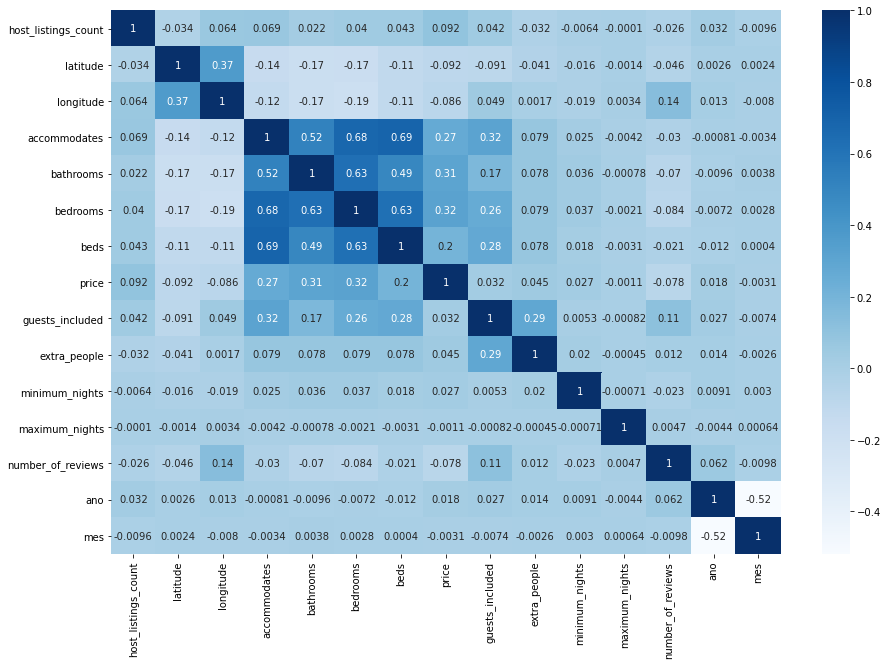

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Blues')

- Definição de funções para **Análise de Outliers**

In [14]:
def limites(coluna):
    #separando quartis
    q1 = coluna.quantile(0.25) #primeiro quartil
    q3 = coluna.quantile(0.75) #terceiro quartil
    amplitude = q3 - q1
    limite_inferior = q1 - 1.5*amplitude
    limite_superior = q3 + 1.5*amplitude
    return limite_inferior, limite_superior

def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[((df[nome_coluna]>=lim_inf) & (df[nome_coluna]<=lim_sup)), :] #colunas dentro dos limites
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas

In [15]:
#Comparando as metricas da feature com os limites calculados
print(limites(base_airbnb['price']))
print(base_airbnb['price'].describe())

(-524.0, 1276.0)
count    897709.000000
mean        648.062195
std        1705.104980
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64


In [16]:
#Graficos e diagramas
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2) #1 linha, 2 colunas para colocar os graficos lado a lado
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15,5))
    #sns.distplot(coluna, hist=True)
    sns.histplot(coluna, kde=True, linewidth=0)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price
- Contém outliers de preços muito altos.
- A decisão de excluir basea-se no fato de que o objetivo é calcular o preço de imóveis comuns (de médio padrão).

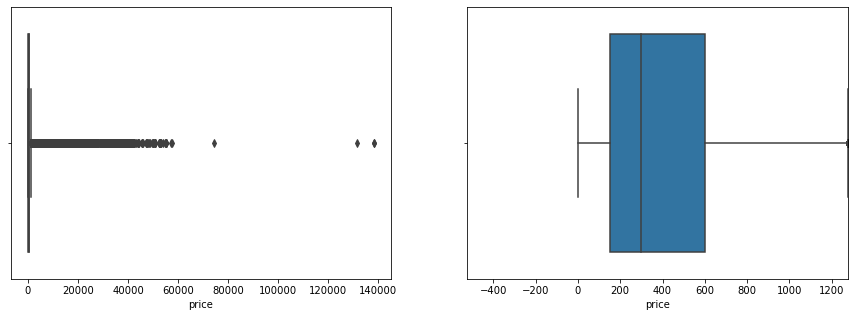

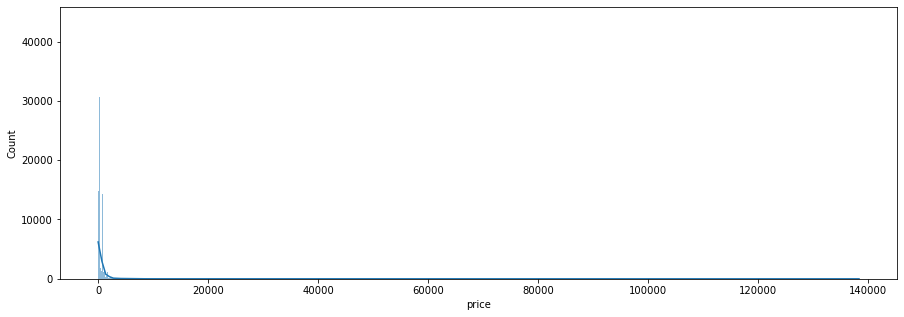

In [17]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como está sendo construído um modelo para imóveis comuns, supõe-se que os valores acima do limite superior referem-se a imóveis de altíssimo luxo, que não são o foco dessa solução. Por isso esses outliers podem ser excluídos.

In [18]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(qtd_linhas))

87282 linhas removidas


Obs.: Poderia ser criado um modelo somente para esses 87282 imóveis.

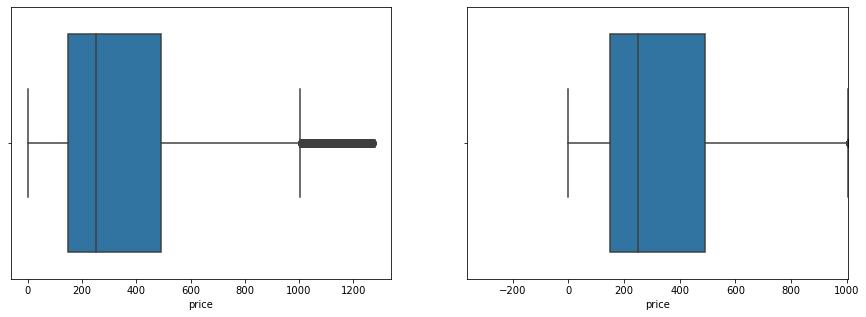

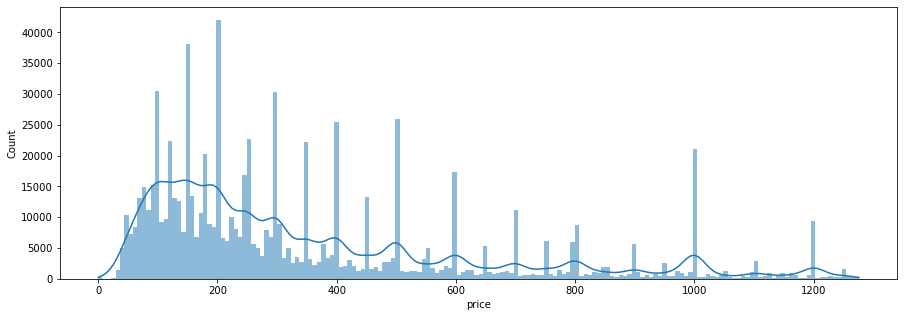

In [19]:
#Graficos após a remoção dos outliers
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

### extra_people

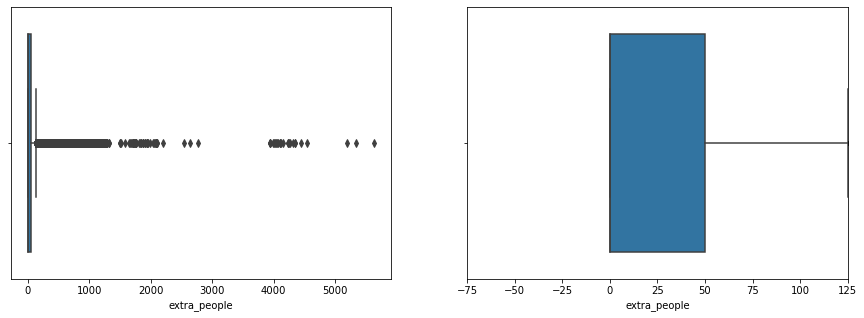

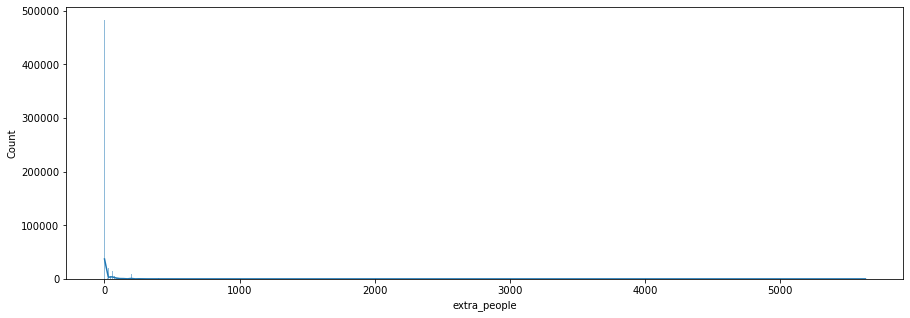

In [20]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [21]:
base_airbnb['extra_people'].value_counts()

0.0       482874
50.0       57798
100.0      41190
30.0       19725
40.0       16195
           ...  
4064.0         1
1689.0         1
570.0          1
702.0          1
1712.0         1
Name: extra_people, Length: 869, dtype: int64

Baseando-se no fato de que a maioria dos valores da feature são 0.0, e que há registros de imóveis com valores bem acima da média, essa coluna será removida.

In [22]:
base_airbnb = base_airbnb.drop('extra_people', axis=1)
base_airbnb.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes'],
      dtype='object')

### host_listings_count

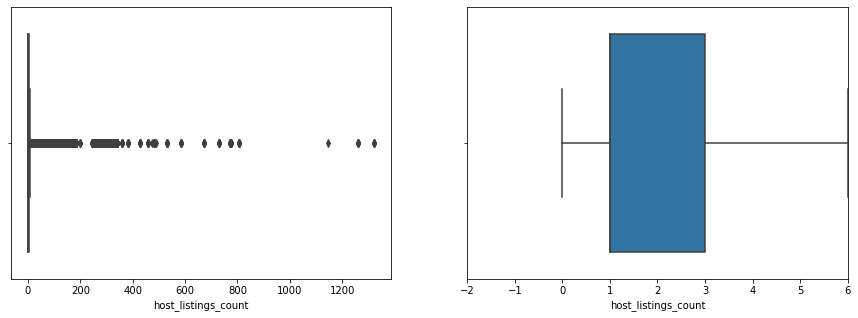

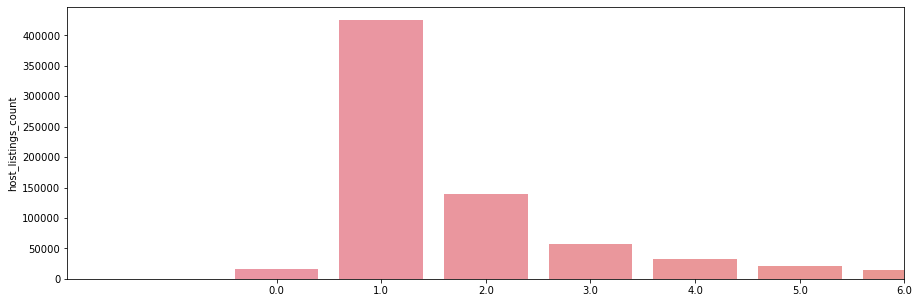

In [23]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Pode-se excluir os outliers porque para o objetivo do projeto, usuários com mais de 6 imóveis não são o alvo.
É possível que esses usuários seja imobiliárias, por exemplo.

In [24]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(qtd_linhas))

102813 linhas removidas


### accommodates

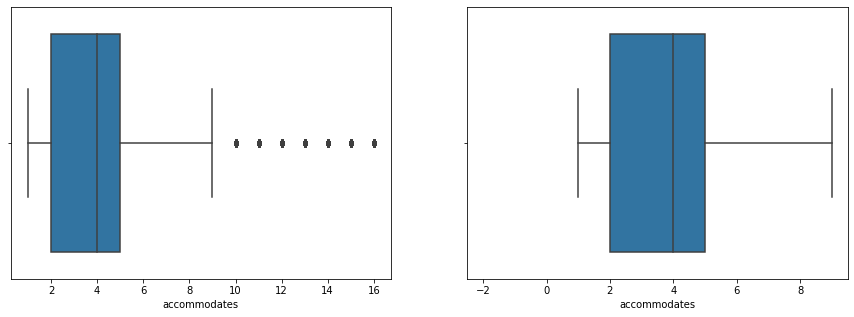

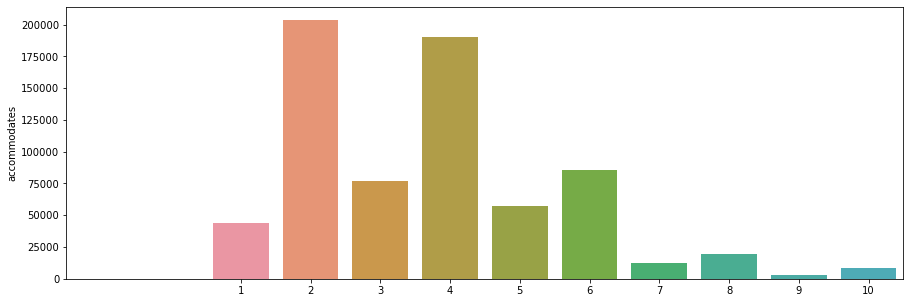

In [25]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

Os outliers serão removidos pelo mesmo motivo da feature 'host_listings_count'

In [26]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(qtd_linhas))

15241 linhas removidas


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

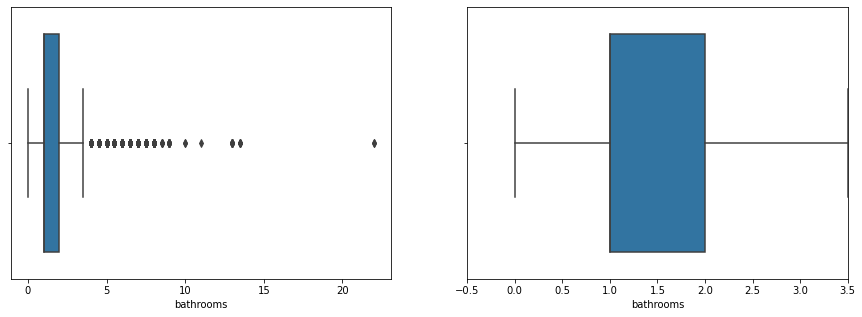

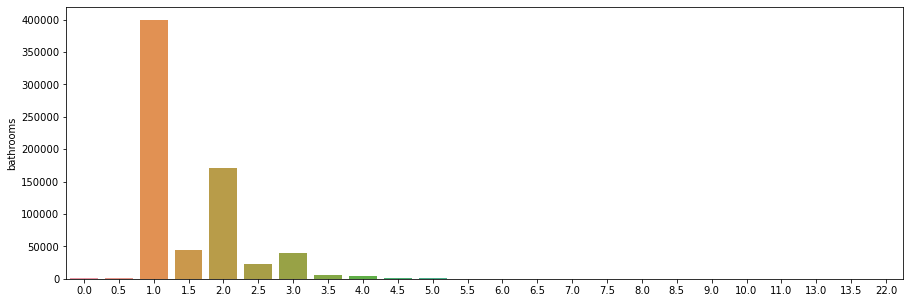

In [27]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

Outliers removidos porque provavelmente fazem parte de características de imóveis de alto padrão.

In [28]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(qtd_linhas))

8311 linhas removidas


### bedrooms

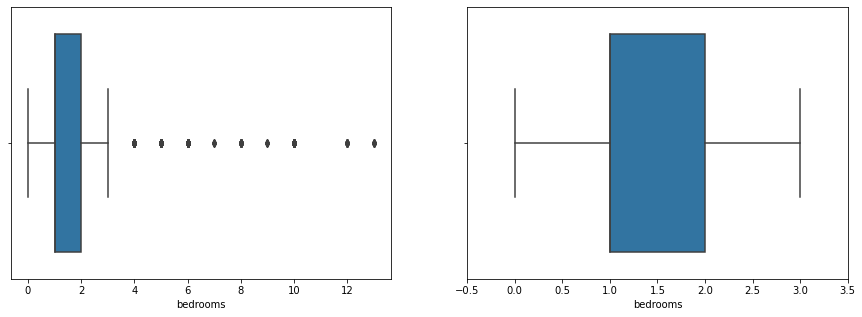

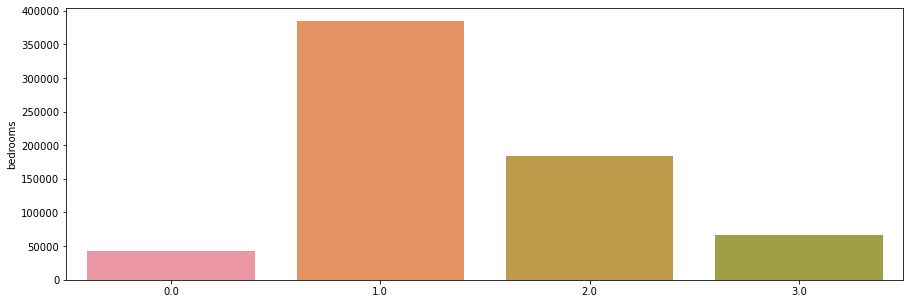

In [29]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

Outliers removidos pelo mesmo motivo da feature 'bathrooms'.

In [30]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(qtd_linhas))

6588 linhas removidas


### beds

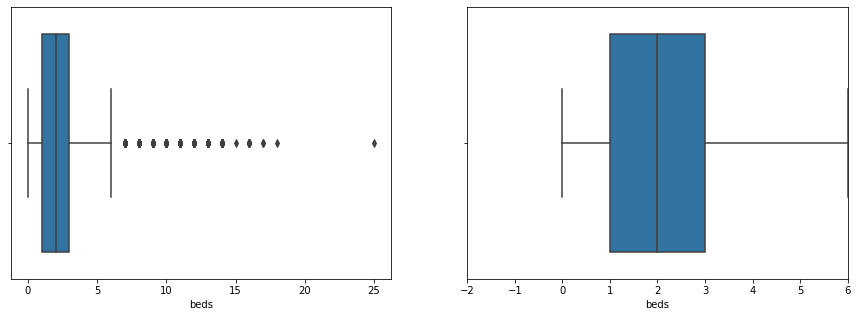

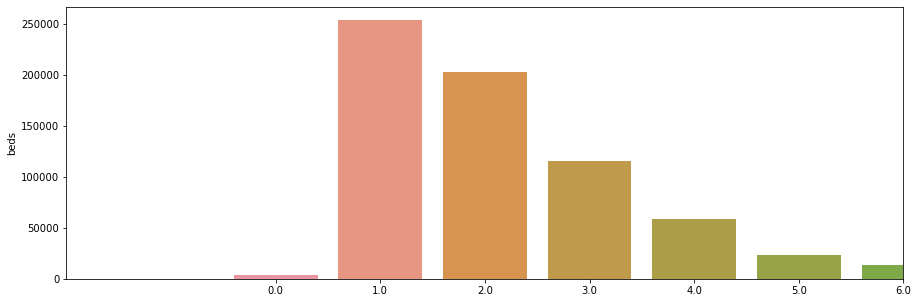

In [31]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

Outliers removidos pelo mesmo motivo da feature 'bathrooms'.

In [32]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(qtd_linhas))

6345 linhas removidas


### guests_included

<AxesSubplot:ylabel='guests_included'>

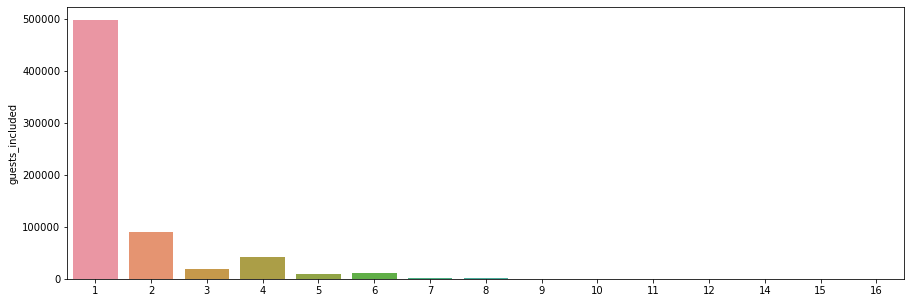

In [33]:
limites(base_airbnb['guests_included'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Essa coluna será removida porque parece que os usuários do Airbnb usando o valor padrão do site como 1 guest incluído. Isso pode fazer com que o modelo considere uma feature/característica que na verdade não é essencial.

In [34]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(671129, 21)

### minimum_nights

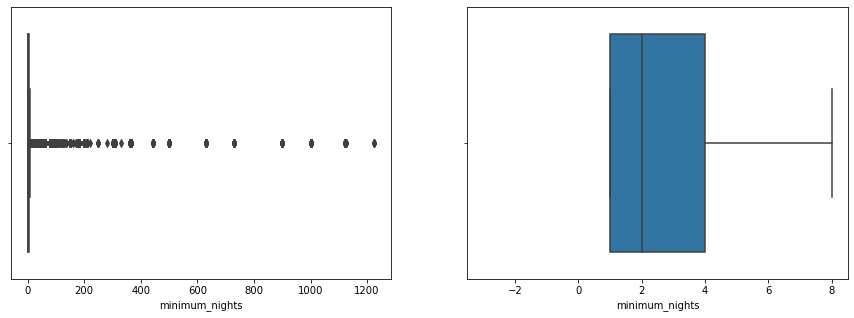

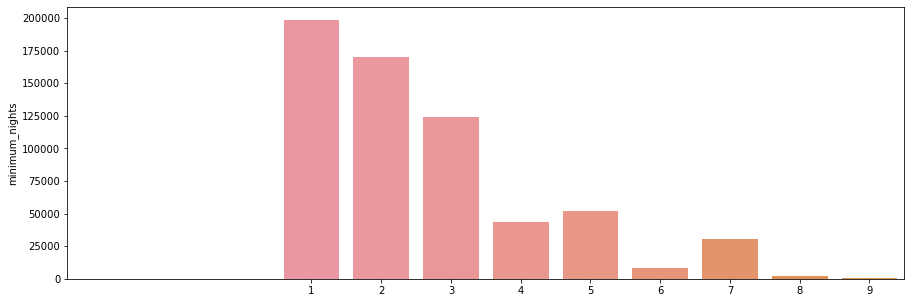

In [35]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [36]:
base_airbnb['minimum_nights'].value_counts()

1      198471
2      170134
3      123840
5       51954
4       43435
        ...  
280         1
62          1
330         1
58          1
96          1
Name: minimum_nights, Length: 84, dtype: int64

Num primeiro momento, essa feature será mantida removendo-se os outliers. Posteriormente será feita uma comparação com um modelo treinado sem essa coluna. 

In [37]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(qtd_linhas))

43307 linhas removidas


### maximum_nights

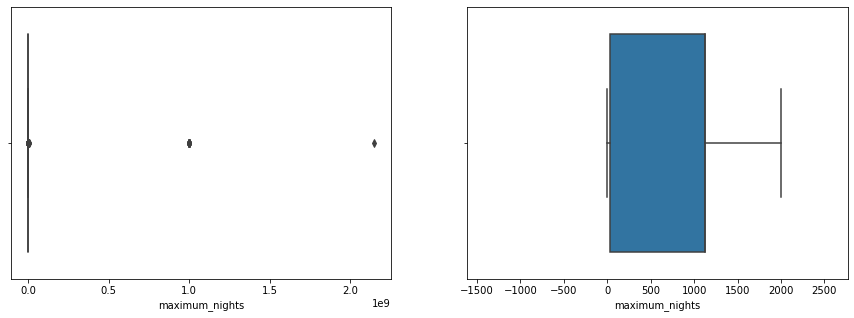

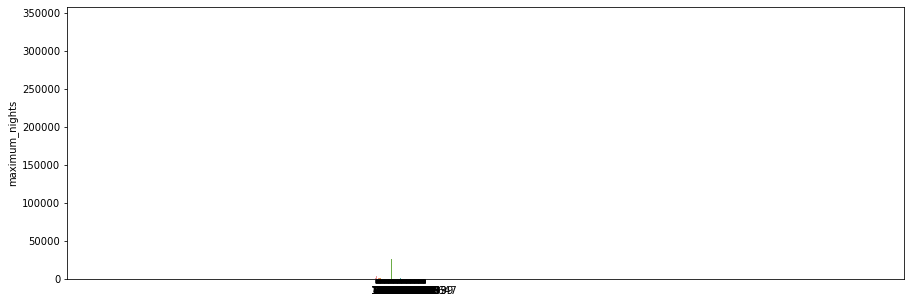

In [38]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

Entendendo que essa feature possui majoritariamente valores discrepantes (ou 0 ou muitas noites), essa coluna será removida.

In [39]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(627822, 20)

### number_of_reviews

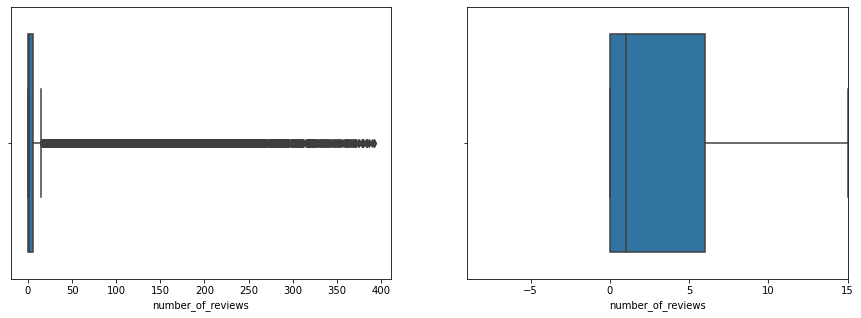

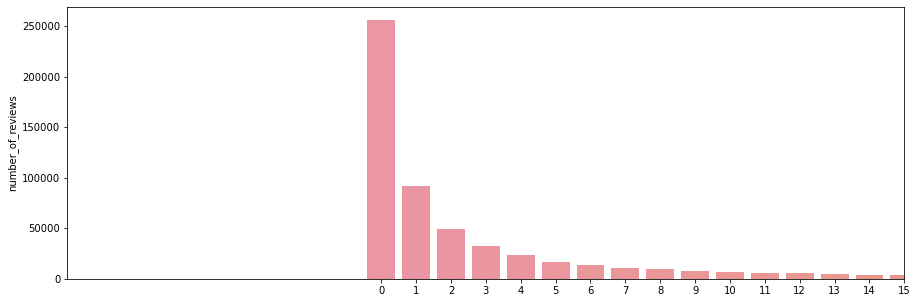

In [40]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Se os outliers forem removidos, serão excluídos hosts que têm a maior quantidade de reviews (o que normalmente são os hosts que têm mais imóveis). Isso pode impactar negativamente o modelo.
- Novos hosts não possuem revews, e como novos hosts são o principal público alvo do modelo, o melhor a fazer é excluir essa feature.

In [41]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(627822, 19)

### Tratamento de Colunas de Valores de Texto

### property_type

In [42]:
base_airbnb['property_type'].value_counts()

Apartment                 495661
House                      54909
Condominium                28816
Serviced apartment         13450
Loft                       13261
Guest suite                 3827
Bed and breakfast           3624
Hostel                      2785
Guesthouse                  2281
Other                       1989
Villa                       1390
Townhouse                   1001
Aparthotel                   724
Chalet                       536
Earth house                  479
Boutique hotel               475
Tiny house                   464
Hotel                        383
Casa particular (Cuba)       305
Cottage                      238
Bungalow                     210
Dorm                         197
Cabin                        141
Nature lodge                 138
Castle                        80
Treehouse                     76
Boat                          54
Island                        54
Resort                        42
Hut                           40
Campsite  

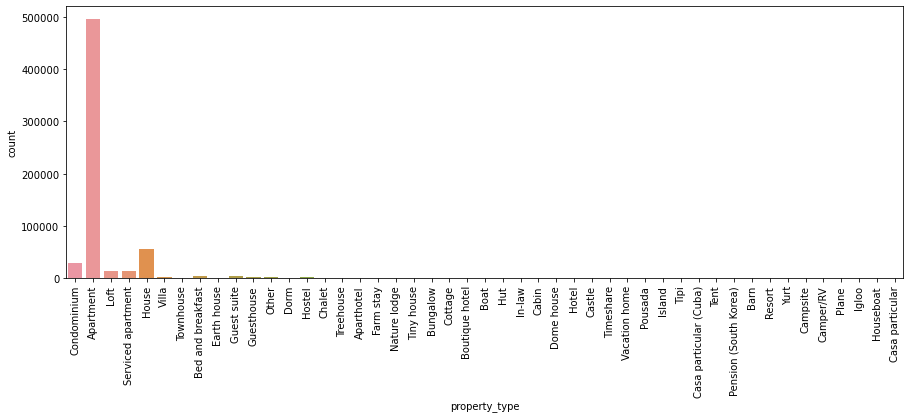

In [43]:
plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)#tracinhos do gráfico

Apartment             495661
House                  54909
Condominium            28816
Serviced apartment     13450
Loft                   13261
Outros                  9208
Guest suite             3827
Bed and breakfast       3624
Hostel                  2785
Guesthouse              2281
Name: property_type, dtype: int64


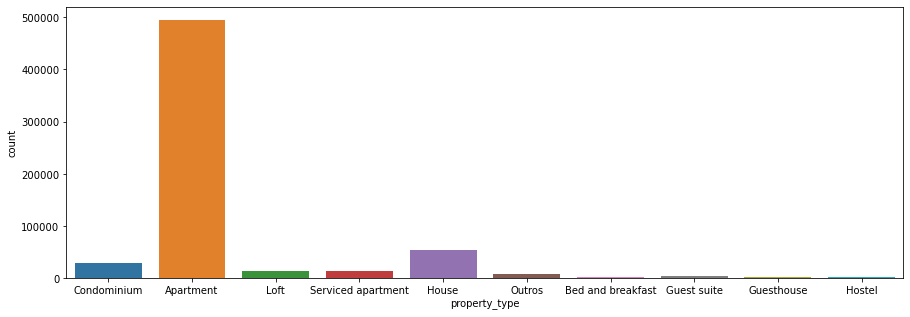

In [44]:
#Agrupando valores abaixo de 2 mil
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'
    
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['property_type'])
#grafico.tick_params(axis='x', rotation=90)#tracinhos do gráfico

### room_type

Entire home/apt    406269
Private room       207700
Shared room         12851
Hotel room           1002
Name: room_type, dtype: int64


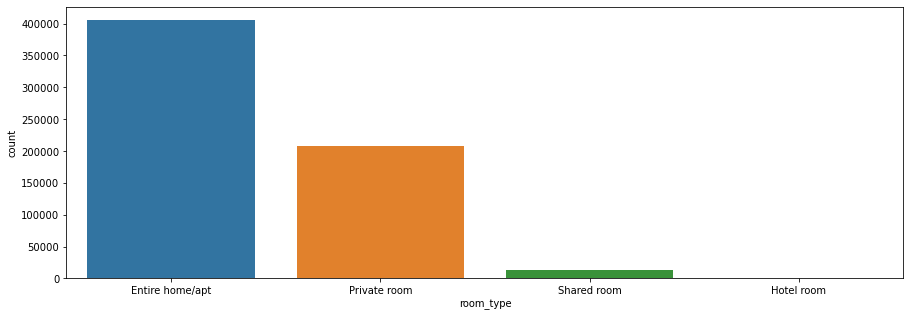

In [45]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['room_type'])
#grafico.tick_params(axis='x', rotation=90)

### bed_type

Real Bed         615749
Pull-out Sofa      8501
Futon              1836
Airbed             1236
Couch               500
Name: bed_type, dtype: int64


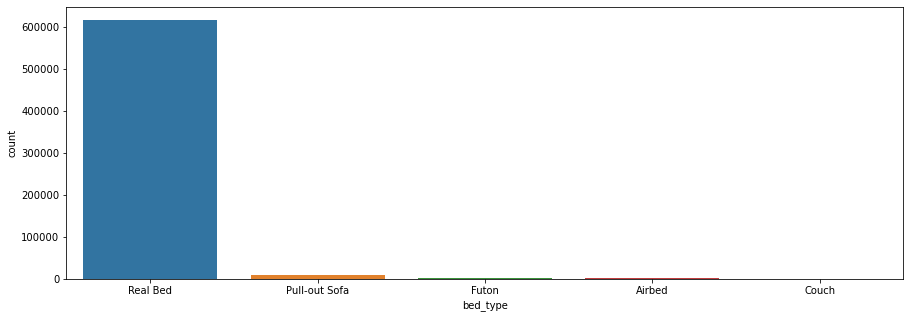

In [46]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['bed_type'])
#grafico.tick_params(axis='x', rotation=90)

- Faz sentido agrupar, pois os valores menores são todos referentes a tipos menos confortáveis de cama.

Real Bed        615749
Outras Camas     12073
Name: bed_type, dtype: int64


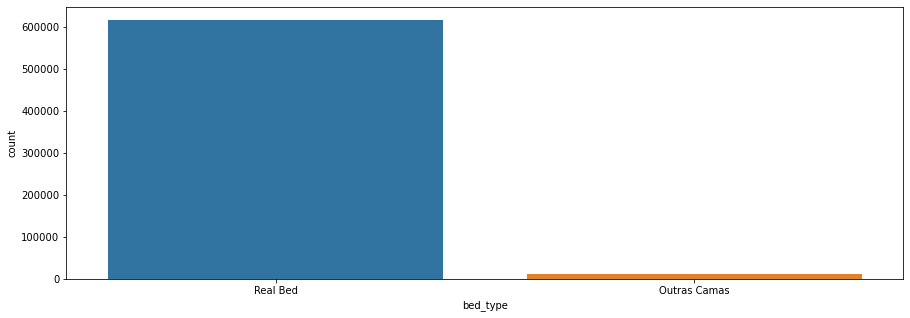

In [47]:
tabela_camas = base_airbnb['bed_type'].value_counts()

colunas_agrupar = []

for tipo in tabela_camas.index:
    if tipo != 'Real Bed':
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outras Camas'
    
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['bed_type'])

### cancellation_policy

flexible                       272249
strict_14_with_grace_period    222210
moderate                       122503
strict                          10693
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


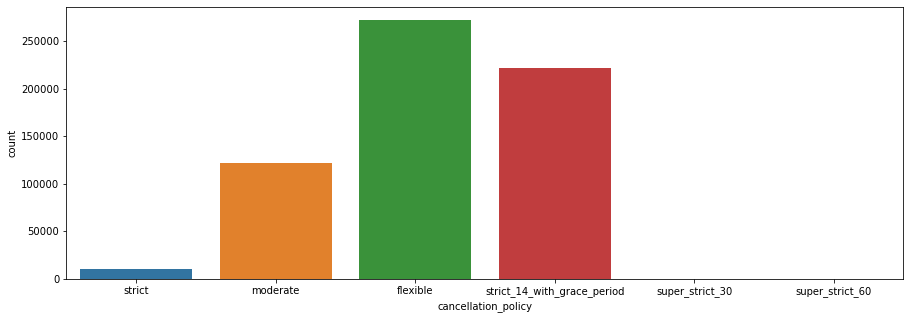

In [48]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
#grafico.tick_params(axis='x', rotation=90)

Agrupando categorias de cancellation_policy

flexible                       272249
strict_14_with_grace_period    222210
moderate                       122503
strict                          10860
Name: cancellation_policy, dtype: int64


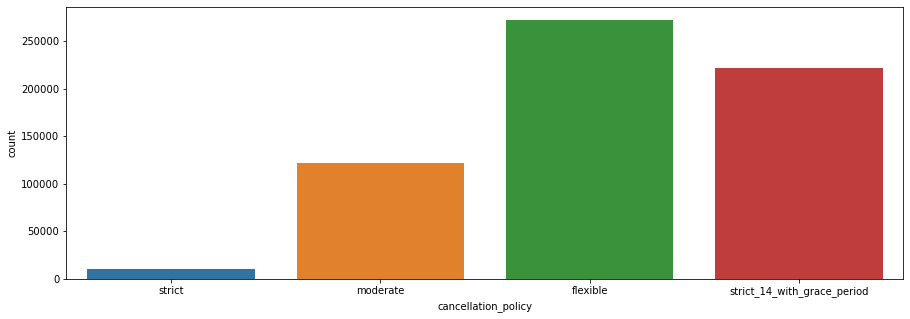

In [49]:
tabela_tipos_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_cancellation.index:
    if tabela_tipos_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
#sns.countplot('property_type', data=base_airbnb)
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])

### amenities

Como há uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, será avalida a quantidade de amenities no lugar de suas descrições.

In [50]:
lista = base_airbnb['amenities'].iloc[1].split(',')
print(lista)
print(len(lista))
#Adicionando coluna com o numero de amenities
base_airbnb['num_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Wifi', '"Air conditioning"', '"First aid kit"', 'Essentials', 'Shampoo', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Hot water"', '"Bed linens"', '"Extra pillows and blankets"', '"Pocket wifi"', 'Microwave', '"Coffee maker"', 'Refrigerator', '"Dishes and silverware"', '"Beach essentials"}']
20


In [51]:
#Removendo a coluna de amenities
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(627822, 19)

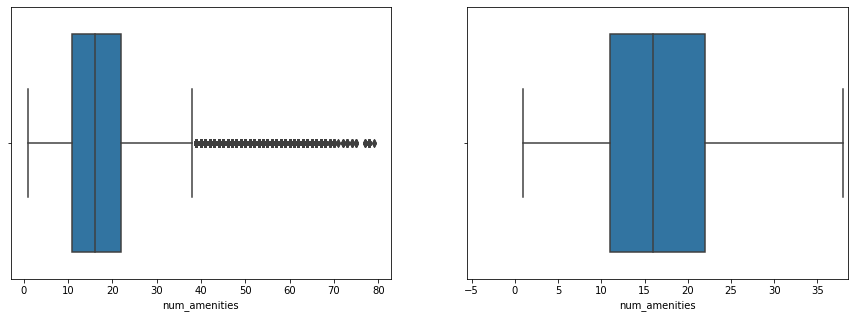

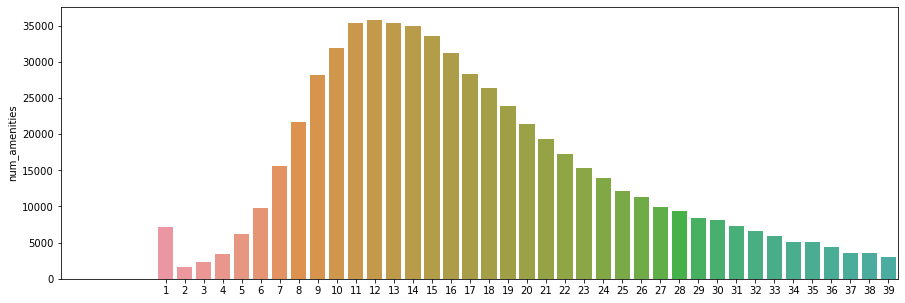

In [52]:
diagrama_caixa(base_airbnb['num_amenities'])
grafico_barra(base_airbnb['num_amenities'])

In [53]:
base_airbnb, qtd_linhas = excluir_outliers(base_airbnb, 'num_amenities')
print('{} linhas removidas'.format(qtd_linhas))

26716 linhas removidas


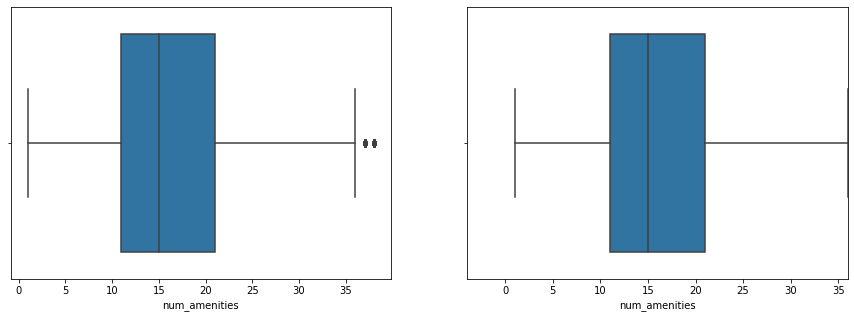

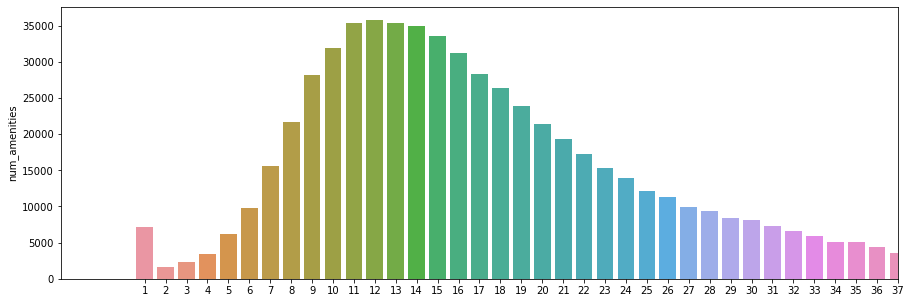

In [54]:
diagrama_caixa(base_airbnb['num_amenities'])
grafico_barra(base_airbnb['num_amenities'])

### Visualização de Mapa das Propriedades

Criando mapa que exibe um pedaço aleatório da base de dados (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço.

In [55]:
df_amostra = base_airbnb.sample(n=50000) #amostra aleatória simples
centro_mapa = {'lat':df_amostra.latitude.mean(), 'lon':df_amostra.longitude.mean()}
mapa = px.density_mapbox(df_amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

É necessário ajustar as features para facilitar o trabalho do modelo (features de categoria, de true e false, etc.)

- Features de Valores _True_ ou _False_, serão substituídas por 1 e 0, respectivamente.
- Nas features de Categoria (features em que os valores da coluna são textos) será aplicado o método de encoding de variáveis _dummies_.

In [56]:
colunas_tf = ['host_is_superhost','instant_bookable', 'is_business_travel_ready']

In [57]:
colunas_categoria = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb.iloc[0]

host_is_superhost                         t
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
minimum_nights                            4
instant_bookable                          t
is_business_travel_ready                  f
cancellation_policy                  strict
ano                                    2018
mes                                       4
num_amenities                            25
Name: 1, dtype: object

In [58]:
#colunas_tf = ['host_is_superhost','instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0
    
base_airbnb_cod.iloc[0]

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
num_amenities                            25
Name: 1, dtype: object

In [59]:
#colunas_categoria = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categoria)
base_airbnb_cod.head()

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
2                 0                  1.0 -22.985698 -43.201935             2   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   

   bathrooms  bedrooms  beds  price  minimum_nights  ...  \
1        1.0       2.0   2.0  270.0               4  ...   
2        1.0       1.0   1.0  222.0               3  ...   
3        1.0       1.0   2.0  161.0               4  ...   
4        1.0       1.0   2.0  222.0               2  ...   
5        1.5       1.0   2.0  308.0               2  ...   

  room_type_Entire home/apt room_type_Hotel room  room_type_Private room  \
1                         1                    0                       0   
2                         1                    0                       0   
3                         1                    0                       0   
4                         1                    0                       0   
5                         1                    0                       0   

   room_type_Shared room  bed_type_Outras Camas  bed_type_Real Bed  \
1                      0                      0                  1   
2                      0                      0                  1   
3                      0                      0                  1   
4                      0                      0                  1   
5                      0                      0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
2                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  

[5 rows x 35 columns]

### Modelo de Previsão

- Definindo métricas de avaliação

In [60]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao)) #raiz do erro quadrático médio
    return f'Modelo {nome_modelo}:\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

**Escolha dos modelos a serem testados**
- Por se tratar da previsão de um valor, o tipo de problema deste projeto enquadra-se na categoria de problemas de regressão linear. Sendo assim, os modelos a serem testados serão: 
    1. RandomForest
    2. LinearRegression
    3. ExtraTree

In [61]:
modelos = {'RandomForest': RandomForestRegressor(),
           'LinearRegression': LinearRegression(),
           'Extra Tree': ExtraTreesRegressor()}

X = base_airbnb_cod.drop('price', axis=1)
y = base_airbnb_cod['price']

- Separar os dados em treino e teste + Treino do modelo

In [62]:
#random_state garante que teremos sempre a mesma divisão aleatória em todas as rodadas
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_treino, y_treino)
    #testar
    previsao = modelo.predict(X_teste)
    print(avaliar_modelo(nome_modelo, y_teste, previsao))

Modelo RandomForest:
R²: 97.21%
RSME: 44.81
Modelo LinearRegression:
R²: 30.34%
RSME: 223.93
Modelo Extra Tree:
R²: 97.39%
RSME: 43.34


### Análise do Melhor Modelo

In [63]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(X_teste)
    print(avaliar_modelo(nome_modelo, y_teste, previsao))

Modelo RandomForest:
R²: 97.21%
RSME: 44.81
Modelo LinearRegression:
R²: 30.34%
RSME: 223.93
Modelo Extra Tree:
R²: 97.39%
RSME: 43.34


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²: 97.38%<br>
RSME: 43.39

### Ajustes e Melhorias no Melhor Modelo

In [64]:
modelo_et = modelos['Extra Tree']
print(modelo_et.feature_importances_)
print(X_teste.columns)

[0.01510451 0.04414046 0.12248189 0.11679142 0.08095239 0.07786835
 0.1127956  0.05930552 0.07036019 0.02398455 0.         0.01331663
 0.00555746 0.1071701  0.01326829 0.00141508 0.00549444 0.00062499
 0.00092842 0.00071889 0.00771112 0.00212327 0.00235412 0.0023347
 0.06211163 0.00025499 0.00461209 0.00185377 0.00258844 0.00261136
 0.01955553 0.01280786 0.00066868 0.00613327]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'ano', 'mes',
       'num_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room

In [65]:
itens = modelo_et.feature_importances_
indices = X_teste.columns
importancia_features = pd.DataFrame(itens, indices)

In [66]:
display(importancia_features)

0
host_is_superhost                                0.015105
host_listings_count                              0.044140
latitude                                         0.122482
longitude                                        0.116791
accommodates                                     0.080952
bathrooms                                        0.077868
bedrooms                                         0.112796
beds                                             0.059306
minimum_nights                                   0.070360
instant_bookable                                 0.023985
is_business_travel_ready                         0.000000
ano                                              0.013317
mes                                              0.005557
num_amenities                                    0.107170
property_type_Apartment                          0.013268
property_type_Bed and breakfast                  0.001415
property_type_Condominium                        0.005494
property_type_Guest suite                        0.000625
property_type_Guesthouse                         0.000928
property_type_Hostel                             0.000719
property_type_House                              0.007711
property_type_Loft                               0.002123
property_type_Outros                             0.002354
property_type_Serviced apartment                 0.002335
room_type_Entire home/apt                        0.062112
room_type_Hotel room                             0.000255
room_type_Private room                           0.004612
room_type_Shared room                            0.001854
bed_type_Outras Camas                            0.002588
bed_type_Real Bed                                0.002611
cancellation_policy_flexible                     0.019556
cancellation_policy_moderate                     0.012808
cancellation_policy_strict                       0.000669
cancellation_policy_strict_14_with_grace_period  0.006133

In [67]:
importancia_features = importancia_features.sort_values(by=0, ascending=False)
importancia_features

0
latitude                                         0.122482
longitude                                        0.116791
bedrooms                                         0.112796
num_amenities                                    0.107170
accommodates                                     0.080952
bathrooms                                        0.077868
minimum_nights                                   0.070360
room_type_Entire home/apt                        0.062112
beds                                             0.059306
host_listings_count                              0.044140
instant_bookable                                 0.023985
cancellation_policy_flexible                     0.019556
host_is_superhost                                0.015105
ano                                              0.013317
property_type_Apartment                          0.013268
cancellation_policy_moderate                     0.012808
property_type_House                              0.007711
cancellation_policy_strict_14_with_grace_period  0.006133
mes                                              0.005557
property_type_Condominium                        0.005494
room_type_Private room                           0.004612
bed_type_Real Bed                                0.002611
bed_type_Outras Camas                            0.002588
property_type_Outros                             0.002354
property_type_Serviced apartment                 0.002335
property_type_Loft                               0.002123
room_type_Shared room                            0.001854
property_type_Bed and breakfast                  0.001415
property_type_Guesthouse                         0.000928
property_type_Hostel                             0.000719
cancellation_policy_strict                       0.000669
property_type_Guest suite                        0.000625
room_type_Hotel room                             0.000255
is_business_travel_ready                         0.000000

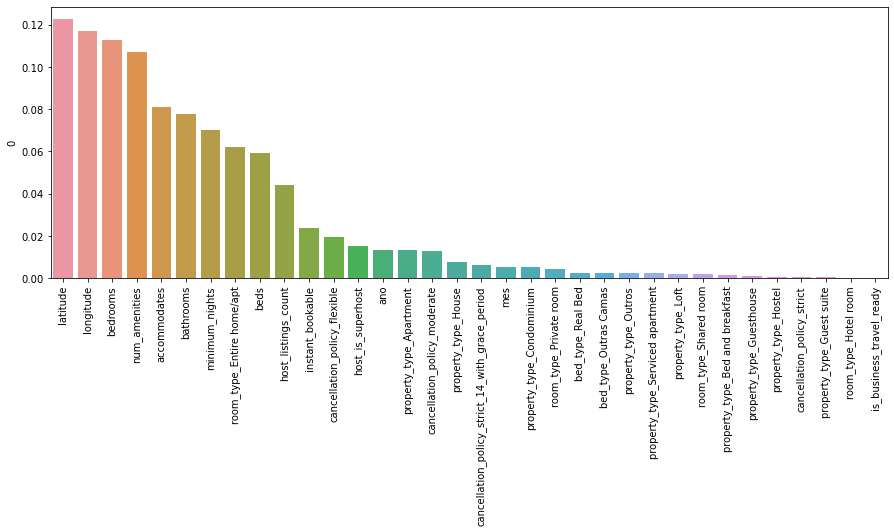

In [68]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel_ready aparentemente não tem muito impacto no modelo. Por isso, para chegar em um modelo mais simples, essa feature será excluída e o modelo será testado sem ela.

In [69]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)
X = base_airbnb_cod.drop('price', axis=1)
y = base_airbnb_cod['price']

In [70]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=10)

modelo_et.fit(X_treino, y_treino)

ExtraTreesRegressor()

In [71]:
previsao = modelo_et.predict(X_teste)
print(avaliar_modelo('ExtraTrees', y_teste, previsao))

'''
Resultado anterior:
Modelo ExtraTrees:
R²: 97.38%
RSME: 43.39
'''

Modelo ExtraTrees:
R²: 97.38%
RSME: 43.40


'\nResultado anterior:\nModelo ExtraTrees:\nR²: 97.38%\nRSME: 43.39\n'

- Testando sem a feature 'minimum_nights'

In [72]:
base2 = base_airbnb_cod.copy()
base2 = base2.drop('minimum_nights', axis=1)

X2 = base2.drop('price', axis=1)
y2 = base2['price']

X_treino2, X_teste2, y_treino2, y_teste2 = train_test_split(X2, y2, random_state=10)

model2 = ExtraTreesRegressor()
model2.fit(X_treino2, y_treino2)

previsao2 = model2.predict(X_teste2)

print(avaliar_modelo('ExtraTrees', y_teste2, previsao2))

Modelo ExtraTrees:
R²: 97.21%
RSME: 44.85


# Comentários finais
Após as etapas de treino e teste, percebeu-se que as características que estão impactando mais no preço final são quantidade de quartos e a localização (latitude e longitude).

Conforme pontuado anteriormente, a localização ser de grande relevância já era esperado tratando-se do Rio de Janeiro. Eu sou natural do Rio, então conheço bem a diferença de preços entre os bairros.

A quantidade de quartos influenciar no preço faz total sentido, visto que quanto maiores forem os imóveis, mais caros e valorizados eles serão.

Achei curioso o fato de que a característica de ser um quarto de hotel não fosse tão relevante no preço da diária. Minha hipótese é de que os usuários do site - tanto hóspedes quanto _hosts_ - não estejam muito interessados em alugar esse tipo de acomodação.

Uma possibilidade futura é unir os tipos de acomodações diferentes de _"Entire home/apt"_, que foi o tipo de propriedade que mostrou influenciar mais o resultado, e ver como isso impactaria a saída do modelo.

Abaixo está descrita a etapa opcional de deploy para que se possa testar o modelo em uma interface simples. Minha intenção é disponibilizar essa interface online para que mais pessoas possam testar o modelo de uma maneira fácil.

# Deploy do Projeto

- Passo 1 -> Salvar os dados num arquivo csv
- Passo 2 -> Criar arquivo do Modelo (joblib)
- Passo 3 -> Escolher a forma de deploy, que neste caso será através da biblioteca Streamlit
- Passo 4 -> Em outro arquivo Python, importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6-> Deploy feito

In [73]:
X['price'] = y
X.to_csv('dados.csv')

In [74]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']